In [446]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as mpl_patches
from scipy import interpolate
import bspline
import bspline.splinelab

In [920]:
def getSpeedVector(x, mult=1):
    m = len(x)
    if len(x.shape) < 2:
        x = np.expand_dims(x,1)
    d = np.sqrt(((x[1:]-x[:-1])**2).sum(axis=1))
    z = []
    zsum = 0
    for i in range(len(x)):
        z.append(zsum)
        if i < m-1:
            if mult > 1:
                zsum += d[i]/mult
                for j in range(mult-1):
                    z.append(zsum)
                    zsum += d[i]/mult
            else:
                zsum += d[i]
    return np.array(z)

def gdk(z, n, k):
    zt = z[1:-1]
    t = []
    for i in range(n):
        t.append(zt[round((len(zt)-1)*(i+1)/(n+1))])
        
    t = np.concatenate(([z.min()]*(k+1), t, [z.max()]*(k+1)))
    return t

def generateDistKnotVector(x, n, k):
    z = getSpeedVector(x)
    z /= z[-1]
    z = z[1:-1]
    t = []
    for i in range(n):
        t.append(z[round((len(z)-1)*(i+1)/(n+1))])
        
    t = np.concatenate(([0]*(k+1), t, [1]*(k+1)))
    return t

def getInterpolatingMidwayControls(path,z,k,cn=-1,lm=0,clamp=True):
    assert cn<=len(path)
    if cn<0:
        cn = len(path)
        
    t = gdk(getSpeedVector(path, mult=2),cn*2-k-2,k)
    bs = bspline.Bspline(t, k)
    B = np.array([bs._Bspline__basis(zi,k) for zi in z])
    B[-1][-1] = 1
    tB = np.zeros((cn*2-1, cn))
    tB[0:2,0] = [1,0.5]
    tB[-2:,-1] = [0.5,1]
    for i in range(1,cn-1):
        tB[i*2-1:i*2+2,i] = [0.5,1,0.5]

    Bhat = B@tB
    K = constructSecondDerMatrix(z)
    if clamp:
        P = np.zeros((cn,cn))
        P[0][0] = P[-1][-1] = 1
        q = np.zeros((cn,path.shape[1]))
        q[0] = path[0]
        q[-1] = path[-1]
        RHS = np.concatenate(((1-lm)*Bhat.T@Bhat+lm*(Bhat.T@K@Bhat),P.T), axis=1)
        RHS = np.concatenate((RHS, np.concatenate((P,np.zeros((cn,cn))),axis=1)),axis=0)
        LHS = np.concatenate(((1-lm)*Bhat.T@path, q), axis=0)
        cz = np.linalg.lstsq(RHS,LHS,rcond=-1)[0]
        c = cz[:cn]
    else:
        c = np.linalg.solve((1-lm)*Bhat.T@Bhat+lm*(Bhat.T@K@Bhat), (1-lm)*Bhat.T@path)
        
    '''cn = np.zeros((len(c)*2-1,path.shape[1]))
    cn[::2] = c
    cn[1::2] = (c[1:] + c[:-1])/2
    cn = cn.T'''

    cn = (tB @ c).T
    
    return (t, cn, k)

def constructSmoothingMatrix(t,n,k):
    AT = np.zeros((n+k+1,n))
    for j in range(n):
        for i in range(k+n+1):
            if i<j+1 or i>j+k+1:
                AT[i][j] = 0
            else:
                roots = np.array(t[i:i+k+2])
                roots = -roots
                # Call the vieta_formula function
                coeffs = vieta_formula(roots, len(roots))
                pi_prime = 0
                for ri in range(1,len(roots)+1):
                    pi_prime += coeffs[ri]*(t[j+k+1]**(ri-1))*ri
                
                #print(i,j, i+1, i-k, len(t), t[j], pi_prime)
                #print(math.factorial(k),(t[i+k+1]-t[i]),pi_prime, t[j+k+1], roots, coeffs)
                AT[i][j] = math.factorial(k)*(t[i+k+1]-t[i])/pi_prime
    return AT.T

def constructSecondDerMatrix(x):
    m = len(x)
    h = x[1:]-x[:-1]
    Q = np.zeros((m,m-2))
    R = np.zeros((m-2,m-2))
    for i in range(m-2):
        Q[i][i] = 1/h[i]
        Q[i+1][i] = -(1/h[i]+1/h[i+1])
        Q[i+2][i] = 1/h[i+1]
        R[i][i] = (h[i]+h[i+1])/3
        if i < m-3:
            R[i+1][i] = R[i][i+1] = h[i+1]/6
            
    return Q @ np.linalg.inv(R) @ Q.T

In [922]:
def spline_path(path, k, lm):
    nc = len(path)
    z = getSpeedVector(path)
    t = gdk(z,nc-k-1,k)
    bs = bspline.Bspline(t, k)
    B = np.array([bs._Bspline__basis(zi,k) for zi in z])
    B[-1][-1] = 1
    
    y = np.concatenate((path.T))
    P = np.zeros((nc, nc))
    #P[0][0] = P[nc-1][nc-1] = 1
    q = np.zeros((nc,2))
    q[0] = path[0]
    q[nc-1] = path[-1]
    
    K = constructSecondDerMatrix(z)
    Beq = ((1-lm)*(B.T @ B)) + (lm * (B.T @ K @ B))
    target = (1-lm)*B.T @ path
    LHS = np.concatenate((np.concatenate((Beq, P.T),axis=1), np.concatenate((P, np.zeros((nc,nc))), axis=1)), axis=0)
    RHS = np.concatenate((target, q),axis=0)
    ctz = np.linalg.lstsq(LHS, RHS, rcond=None)[0]
    c = ctz[:nc]
    return (t,c.T,k)

In [680]:
x1 = np.arange(0,20,0.5)
y1 = 9*(x1**0.4)

x2 = np.arange(5,30,0.5)
y2 = 9*(x2**0.3)

p1 = np.array([x1,y1]).T
p2 = np.array([x2,y2]).T

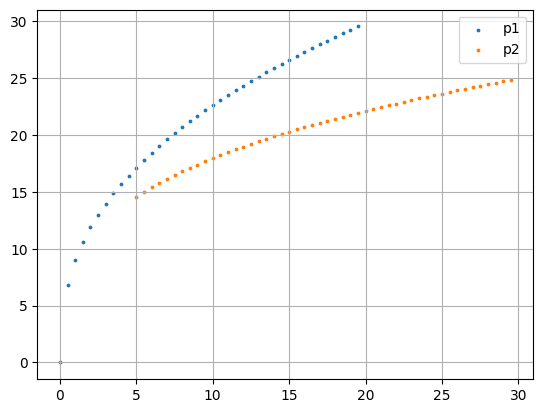

In [690]:
plt.scatter(x1,y1, label='p1', s=3)
plt.scatter(x2,y2, label='p2', s=3)
plt.legend()
plt.grid()
xl,yl = plt.xlim(), plt.ylim()
plt.show()

In [769]:
def get_proj_idx(path_1, path_2, clean=False):
    idx = np.array([np.linalg.norm(path_2-p, axis=1).argmin() for p in path_1])
    if clean:
        idx = np.unique(idx)
        idx.sort()
        
    return idx

def get_path_by_idx(path, idx):
    return [path[i] for i in idx]

#from [0,1] to [0,infty]
def transform_alpha_pow(a):
    a = 1-a
    if a==0:
        return 0
    elif a>0.9:
        a=0.9
    a = -1/np.log2(a)
    return a

In [771]:
def getProj(p1,p2):
    idx1 = get_proj_idx(p2,p1, clean=True)
    proj1 = np.array(get_path_by_idx(p1,idx1))
    
    idx2 = get_proj_idx(proj1,p2)
    proj2 = np.array(get_path_by_idx(p2,idx2))

    return proj1, proj2, idx1, idx2

proj1, proj2, idx1, idx2 = getProj(p1,p2)

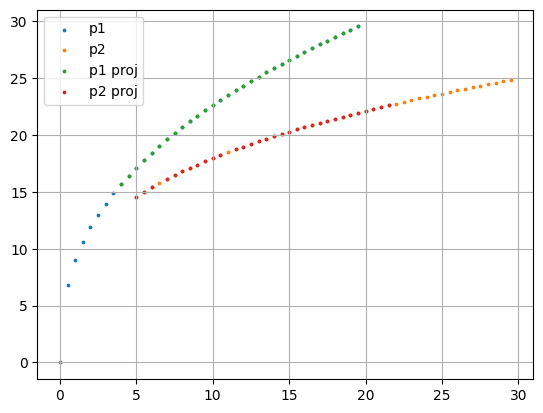

In [773]:
plt.scatter(x1,y1, label='p1', s=3)
plt.scatter(x2,y2, label='p2', s=3)
plt.scatter(*proj1.T, label='p1 proj', s=3)
plt.scatter(*proj2.T, label='p2 proj', s=3)
plt.legend()
plt.grid()
plt.xlim(xl)
plt.ylim(yl)
plt.show()

In [698]:
colors = {'cyan':[52, 201, 235], 'blue':[52, 101, 235], 'red':[232, 19, 40], 'orange':[209, 125, 15]}

for color in colors:
    colors[color] = np.array(colors[color])/255.

In [700]:
R1,R2 = 10,15

In [750]:
proj1[R1:,1].min(),proj2[R1:,1].min()

(21.674022167526232, 18.22213665081809)

theta:  19.1346787212236


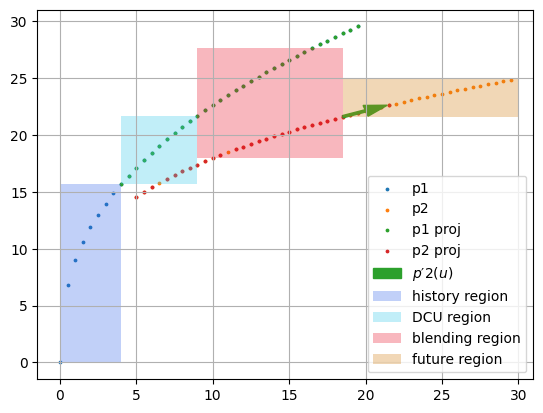

In [819]:
ax = plt.gca()
plt.scatter(x1,y1, label='p1', s=3)
plt.scatter(x2,y2, label='p2', s=3)
plt.scatter(*proj1.T, label='p1 proj', s=3)
plt.scatter(*proj2.T, label='p2 proj', s=3)

history = p1[:idx1.min()+1]
history_start = np.array([history[:,0].min(),history[:,1].min()])
history_end = np.array([history[:,0].max(),history[:,1].max()])

r1 = mpl_patches.Rectangle(history_start, *history_end-history_start, label='history region', facecolor=(*colors['blue'], 0.3))

dcu_start = np.array([proj1[:,0].min(), proj1[:,1].min()])
dcu_end = np.array([p1[idx1.min():idx1.min()+R1+1,0].max(), p1[idx1.min():idx1.min()+R1+1,1].max()])
dcu_end -= dcu_start
r2 = mpl_patches.Rectangle(dcu_start,*dcu_end, label='DCU region', facecolor=(*colors['cyan'], 0.3))

blending_start = np.array([min(p1[idx1.min()+R1:,0].min(),p2[idx2.min()+R1:,0].min()), min(p1[idx1.min()+R1:,1].min(), p2[idx2.min()+R1:,1].min())])
blending_end = np.array([max(proj1[:R1+R2+1,0].max(),proj2[:R1+R2+1,0].max()), max(proj1[:R1+R2+1,1].max(),proj2[:R1+R2+1,1].max())])
blending_end -= blending_start

r3 = mpl_patches.Rectangle(blending_start,*blending_end, label='blending region', facecolor=(*colors['red'], 0.3))
r3.set_facecolor((*colors['red'], 0.3))

future_start = np.array([proj2[R1+R2:,0].min(),proj2[R1+R2:,1].min()])
future_end = p2[-1] - future_start + np.abs(p2[-1]-p2[-2])

r4 = mpl_patches.Rectangle(future_start, *future_end, label='future region', facecolor=(*colors['orange'], 0.3))

dx,dy = proj2[R1+R2+1]-proj2[R1+R2]
theta = np.arctan(dy/dx)
print("theta: ", theta*180/np.pi)

plt.arrow(*proj2[R1+R2], dx*3, dy*3, shape='full', width=0.2, head_width=1, color='tab:green', label="p′2(u)p′2(u)")

rects = [r1,r2,r3,r4]
for r in rects:
    ax.add_patch(r)
plt.legend()
plt.grid()
plt.xlim(xl)
plt.ylim(yl)
plt.show()

theta:  19.1346787212236


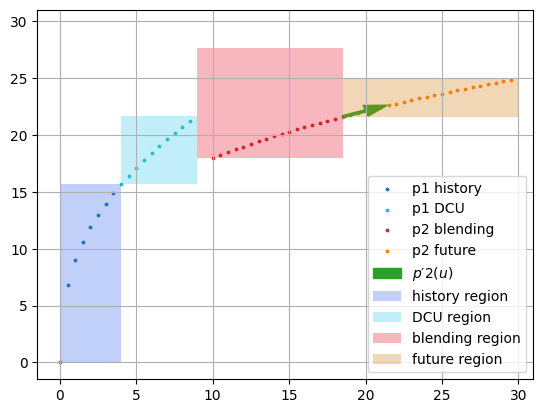

In [833]:
ax = plt.gca()
plt.scatter(*p1[:idx1.min()].T, label='p1 history', s=3, color='tab:blue')
plt.scatter(*p1[idx1.min():idx1.min()+R1].T, label='p1 DCU', s=3, color='tab:cyan')
plt.scatter(*p2[idx2.min()+R1:idx2.min()+R1+R2+2].T, label='p2 blending', s=3, color='tab:red')
plt.scatter(*p2[idx2.min()+R1+R2+2:].T, label='p2 future', s=3, color='tab:orange')

history = p1[:idx1.min()+1]
history_start = np.array([history[:,0].min(),history[:,1].min()])
history_end = np.array([history[:,0].max(),history[:,1].max()])

r1 = mpl_patches.Rectangle(history_start, *history_end-history_start, label='history region', facecolor=(*colors['blue'], 0.3))

dcu_start = np.array([proj1[:,0].min(), proj1[:,1].min()])
dcu_end = np.array([p1[idx1.min():idx1.min()+R1+1,0].max(), p1[idx1.min():idx1.min()+R1+1,1].max()])
dcu_end -= dcu_start
r2 = mpl_patches.Rectangle(dcu_start,*dcu_end, label='DCU region', facecolor=(*colors['cyan'], 0.3))

blending_start = np.array([min(p1[idx1.min()+R1:,0].min(),p2[idx2.min()+R1:,0].min()), min(p1[idx1.min()+R1:,1].min(), p2[idx2.min()+R1:,1].min())])
blending_end = np.array([max(proj1[:R1+R2+1,0].max(),proj2[:R1+R2+1,0].max()), max(proj1[:R1+R2+1,1].max(),proj2[:R1+R2+1,1].max())])
blending_end -= blending_start

r3 = mpl_patches.Rectangle(blending_start,*blending_end, label='blending region', facecolor=(*colors['red'], 0.3))
r3.set_facecolor((*colors['red'], 0.3))

future_start = np.array([proj2[R1+R2:,0].min(),proj2[R1+R2:,1].min()])
future_end = p2[-1] - future_start + np.abs(p2[-1]-p2[-2])

r4 = mpl_patches.Rectangle(future_start, *future_end, label='future region', facecolor=(*colors['orange'], 0.3))

dx,dy = proj2[R1+R2+1]-proj2[R1+R2]
theta = np.arctan(dy/dx)
print("theta: ", theta*180/np.pi)

plt.arrow(*proj2[R1+R2], dx*3, dy*3, shape='full', width=0.2, head_width=1, color='tab:green', label="p′2(u)p′2(u)")

rects = [r1,r2,r3,r4]
for r in rects:
    ax.add_patch(r)
plt.legend()
plt.grid()
plt.xlim(xl)
plt.ylim(yl)
plt.show()

In [835]:
l1 = len(p1[:idx1.min()])
l2=len(p1[idx1.min():idx1.min()+R1])
l3=len(p2[idx2.min()+R1:idx2.min()+R1+R2+2])
l4=len(p2[idx2.min()+R1+R2+2:])

In [849]:
w=np.concatenate(([1]*l1, np.linspace(1,0,l2), np.linspace(0,1,l3), [1]*l4))

theta:  19.1346787212236


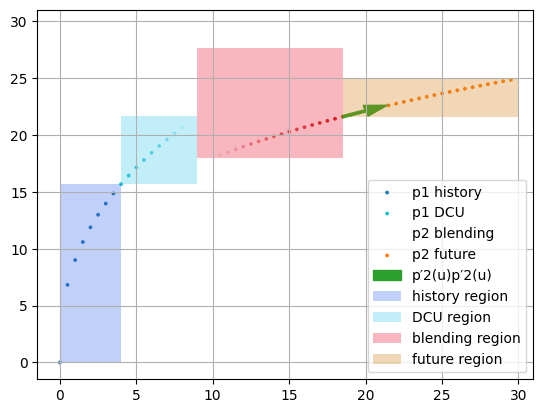

In [859]:
ax = plt.gca()
plt.scatter(*p1[:idx1.min()].T, label='p1 history', s=3, color='tab:blue', alpha=[1]*l1)
plt.scatter(*p1[idx1.min():idx1.min()+R1].T, label='p1 DCU', s=3, color='tab:cyan', alpha=np.linspace(1,0,l2))
plt.scatter(*p2[idx2.min()+R1:idx2.min()+R1+R2+2].T, label='p2 blending', s=3, color='tab:red', alpha=np.linspace(0,1,l3))
plt.scatter(*p2[idx2.min()+R1+R2+2:].T, label='p2 future', s=3, color='tab:orange',alpha=[1]*l4)

history = p1[:idx1.min()+1]
history_start = np.array([history[:,0].min(),history[:,1].min()])
history_end = np.array([history[:,0].max(),history[:,1].max()])

r1 = mpl_patches.Rectangle(history_start, *history_end-history_start, label='history region', facecolor=(*colors['blue'], 0.3))

dcu_start = np.array([proj1[:,0].min(), proj1[:,1].min()])
dcu_end = np.array([p1[idx1.min():idx1.min()+R1+1,0].max(), p1[idx1.min():idx1.min()+R1+1,1].max()])
dcu_end -= dcu_start
r2 = mpl_patches.Rectangle(dcu_start,*dcu_end, label='DCU region', facecolor=(*colors['cyan'], 0.3))

blending_start = np.array([min(p1[idx1.min()+R1:,0].min(),p2[idx2.min()+R1:,0].min()), min(p1[idx1.min()+R1:,1].min(), p2[idx2.min()+R1:,1].min())])
blending_end = np.array([max(proj1[:R1+R2+1,0].max(),proj2[:R1+R2+1,0].max()), max(proj1[:R1+R2+1,1].max(),proj2[:R1+R2+1,1].max())])
blending_end -= blending_start

r3 = mpl_patches.Rectangle(blending_start,*blending_end, label='blending region', facecolor=(*colors['red'], 0.3))
r3.set_facecolor((*colors['red'], 0.3))

future_start = np.array([proj2[R1+R2:,0].min(),proj2[R1+R2:,1].min()])
future_end = p2[-1] - future_start + np.abs(p2[-1]-p2[-2])

r4 = mpl_patches.Rectangle(future_start, *future_end, label='future region', facecolor=(*colors['orange'], 0.3))

dx,dy = proj2[R1+R2+1]-proj2[R1+R2]
theta = np.arctan(dy/dx)
print("theta: ", theta*180/np.pi)

plt.arrow(*proj2[R1+R2], dx*3, dy*3, shape='full', width=0.2, head_width=1, color='tab:green', label="p′2(u)p′2(u)")

rects = [r1,r2,r3,r4]
for r in rects:
    ax.add_patch(r)
plt.legend()
plt.grid()
plt.xlim(xl)
plt.ylim(yl)
plt.show()

In [845]:
w = np.exp(w)
w /= w.sum()

In [851]:
w

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.88888889,
       0.77777778, 0.66666667, 0.55555556, 0.44444444, 0.33333333,
       0.22222222, 0.11111111, 0.        , 0.        , 0.0625    ,
       0.125     , 0.1875    , 0.25      , 0.3125    , 0.375     ,
       0.4375    , 0.5       , 0.5625    , 0.625     , 0.6875    ,
       0.75      , 0.8125    , 0.875     , 0.9375    , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ])

In [1004]:
w

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.88888889,
       0.77777778, 0.66666667, 0.55555556, 0.44444444, 0.33333333,
       0.22222222, 0.11111111, 0.        , 0.        , 0.0625    ,
       0.125     , 0.1875    , 0.25      , 0.3125    , 0.375     ,
       0.4375    , 0.5       , 0.5625    , 0.625     , 0.6875    ,
       0.75      , 0.8125    , 0.875     , 0.9375    , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ])

In [1000]:
path.shape, w.shape

((58, 2), (58,))

In [956]:
def spline_path(path, k, lm, w):
    nc = len(path)
    z = getSpeedVector(path)
    t = gdk(z,nc-k-1,k)
    bs = bspline.Bspline(t, k)
    B = np.array([bs._Bspline__basis(zi,k) for zi in z])
    B[-1][-1] = 1
    
    y = np.concatenate((path.T))
    P = np.zeros((nc, nc))
    #P[0][0] = P[nc-1][nc-1] = 1
    q = np.zeros((nc,2))
    q[0] = path[0]
    q[nc-1] = path[-1]
    
    K = constructSecondDerMatrix(z)
    Beq = ((1-lm)*(w*B.T @ B)) + (lm * (B.T @ K @ B))
    target = (1-lm)*w*(B.T @ path)
    LHS = np.concatenate((np.concatenate((Beq, P.T),axis=1), np.concatenate((P, np.zeros((nc,nc))), axis=1)), axis=0)
    RHS = np.concatenate((target, q),axis=0)
    ctz = np.linalg.lstsq(LHS, RHS, rcond=None)[0]
    c = ctz[:nc]


In [1122]:
path = np.concatenate((p1[:idx1.min()],p1[idx1.min():idx1.min()+R1],p2[idx2.min()+R1:idx2.min()+R1+R2+2],p2[idx2.min()+R1+R2+2:]))
w1 = [1]*l1
w2 = [1]*l2
w3 = [0.01]*l3#np.linspace(0,1,l3)**4
w4 = [1]*l4
ws = [w1,w2,w3,w4]
w=np.concatenate(ws)
#np.linspace(1,0,l2)**0.5
#w[0] = w[-1] = 10
#w = np.exp(w)
w = w/w.sum()
tck,_=interpolate.splprep(path.T,s=1,w=w)
path.shape

(58, 2)

theta:  19.1346787212236


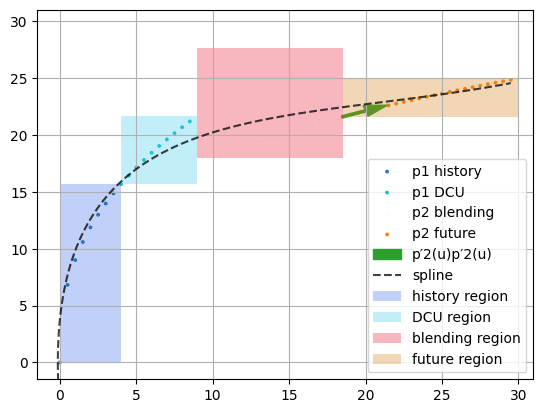

In [1124]:
ax = plt.gca()
plt.scatter(*p1[:idx1.min()].T, label='p1 history', s=3, color='tab:blue', alpha=w1)
plt.scatter(*p1[idx1.min():idx1.min()+R1].T, label='p1 DCU', s=3, color='tab:cyan', alpha=w2)
plt.scatter(*p2[idx2.min()+R1:idx2.min()+R1+R2+2].T, label='p2 blending', s=3, color='tab:red', alpha=w3)
plt.scatter(*p2[idx2.min()+R1+R2+2:].T, label='p2 future', s=3, color='tab:orange',alpha=w4)

history = p1[:idx1.min()+1]
history_start = np.array([history[:,0].min(),history[:,1].min()])
history_end = np.array([history[:,0].max(),history[:,1].max()])

r1 = mpl_patches.Rectangle(history_start, *history_end-history_start, label='history region', facecolor=(*colors['blue'], 0.3))

dcu_start = np.array([proj1[:,0].min(), proj1[:,1].min()])
dcu_end = np.array([p1[idx1.min():idx1.min()+R1+1,0].max(), p1[idx1.min():idx1.min()+R1+1,1].max()])
dcu_end -= dcu_start
r2 = mpl_patches.Rectangle(dcu_start,*dcu_end, label='DCU region', facecolor=(*colors['cyan'], 0.3))

blending_start = np.array([min(p1[idx1.min()+R1:,0].min(),p2[idx2.min()+R1:,0].min()), min(p1[idx1.min()+R1:,1].min(), p2[idx2.min()+R1:,1].min())])
blending_end = np.array([max(proj1[:R1+R2+1,0].max(),proj2[:R1+R2+1,0].max()), max(proj1[:R1+R2+1,1].max(),proj2[:R1+R2+1,1].max())])
blending_end -= blending_start

r3 = mpl_patches.Rectangle(blending_start,*blending_end, label='blending region', facecolor=(*colors['red'], 0.3))
r3.set_facecolor((*colors['red'], 0.3))

future_start = np.array([proj2[R1+R2:,0].min(),proj2[R1+R2:,1].min()])
future_end = p2[-1] - future_start + np.abs(p2[-1]-p2[-2])

r4 = mpl_patches.Rectangle(future_start, *future_end, label='future region', facecolor=(*colors['orange'], 0.3))

dx,dy = proj2[R1+R2+1]-proj2[R1+R2]
theta = np.arctan(dy/dx)
print("theta: ", theta*180/np.pi)

plt.arrow(*proj2[R1+R2], dx*3, dy*3, shape='full', width=0.2, head_width=1, color='tab:green', label="p′2(u)p′2(u)")

x = np.linspace(0,1,101)
y = interpolate.splev(x,tck)

plt.plot(*y, '--', color='black', alpha=0.75, label='spline')

rects = [r1,r2,r3,r4]
for r in rects:
    ax.add_patch(r)
plt.legend()
plt.grid()
plt.xlim(xl)
plt.ylim(yl)
plt.show()

In [803]:
min(proj1[R1:,1].min(), proj2[R1:,1].min()), proj2[R1:,1].min(), p2[R1], proj2[R1]

(18.22213665081809,
 18.22213665081809,
 array([10.        , 17.95736083]),
 array([10.5       , 18.22213665]))

In [600]:
future_start, p2[-1]

(array([[ 5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ,
         10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5,
         16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5],
        [ 5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ,
         10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5,
         16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5]]),
 array([29.5       ,  2.76023847]))

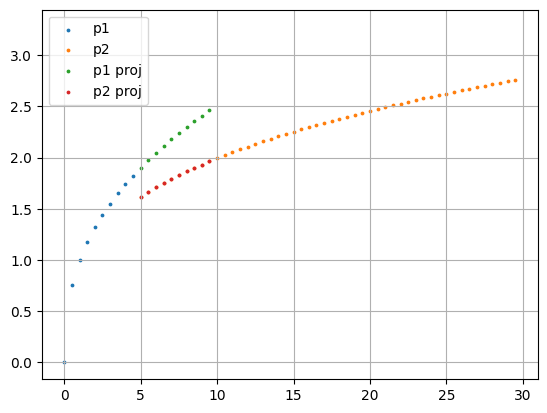

In [211]:
proj1 = proj1[:MAXPROJ]
proj2 = proj2[:MAXPROJ]
plt.scatter(*p1[:idx1.min()].T, label='p1', s=3)
plt.scatter(x2,y2, label='p2', s=3)
plt.scatter(*proj1.T, label='p1 proj', s=3)
plt.scatter(*proj2.T, label='p2 proj', s=3)
plt.legend()
plt.grid()
plt.xlim(xl)
plt.ylim(yl)
plt.show()

In [214]:
def getMerged(proj1, proj2, alpha_pow = 0.5):
    alpha_pow = transform_alpha_pow(alpha_pow)
    merged = []
    al = 0
    for i in range(len(proj1)):
        a = al ** alpha_pow
        merged.append((1-a)*proj1[i] + a*proj2[i])
        al += 1/(len(proj1)-1)
    merged = np.array(merged)
    return merged

merged = getMerged(proj1, proj2)

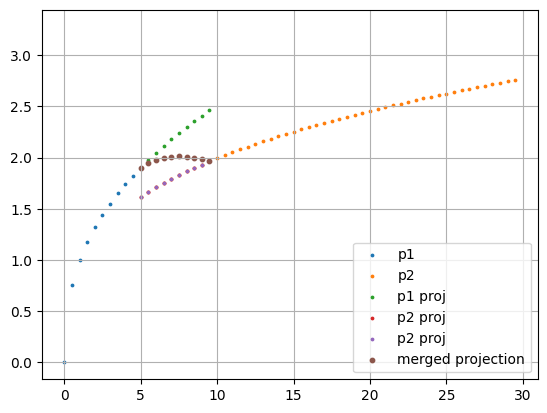

In [216]:
plt.scatter(*p1[:idx1.min()].T, label='p1', s=3)
plt.scatter(*p2.T, label='p2', s=3)
plt.scatter(*proj1.T, label='p1 proj', s=3)
plt.scatter(*proj2.T, label='p2 proj', s=3)
plt.scatter(*proj2.T, label='p2 proj', s=3)
plt.scatter(*merged.T, label='merged projection', s=10)
plt.legend()
plt.grid()
plt.xlim(xl)
plt.ylim(yl)
plt.show()

In [218]:
def addTail(merged,p2,idx2):
    merged = np.concatenate((merged,p2[idx2[min(MAXPROJ-1,len(idx2)-1)]+1:]),axis=0)
    return merged

def addOldHead(merged,p1,idx1):
    merged = np.concatenate((p1[:idx1.min()],merged),axis=0)
    return merged

merged = addTail(merged,p2,idx2)
merged = addOldHead(merged,p1,idx1)

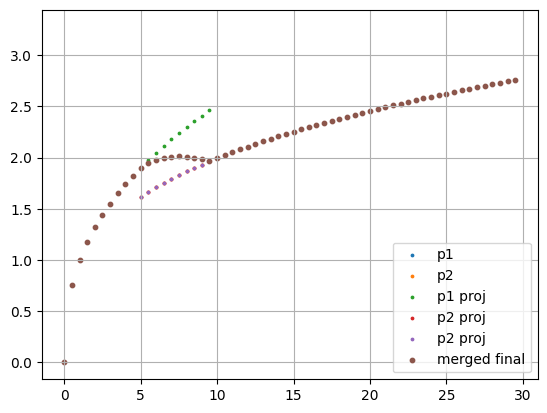

In [220]:
plt.scatter(*p1[:idx1.min()].T, label='p1', s=3)
plt.scatter(*p2.T, label='p2', s=3)
plt.scatter(*proj1.T, label='p1 proj', s=3)
plt.scatter(*proj2.T, label='p2 proj', s=3)
plt.scatter(*proj2.T, label='p2 proj', s=3)
plt.scatter(*merged.T, label='merged final', s=10)
plt.legend()
plt.grid()
plt.xlim(xl)
plt.ylim(yl)
plt.show()

In [290]:
w = [1]*len(merged)
w[0]=w[-1]=12
w = np.exp(w)
w/=w.sum()
tck,_ = interpolate.splprep(merged.T, w=w)
x = np.linspace(0,1,101)
y = interpolate.splev(x,tck)

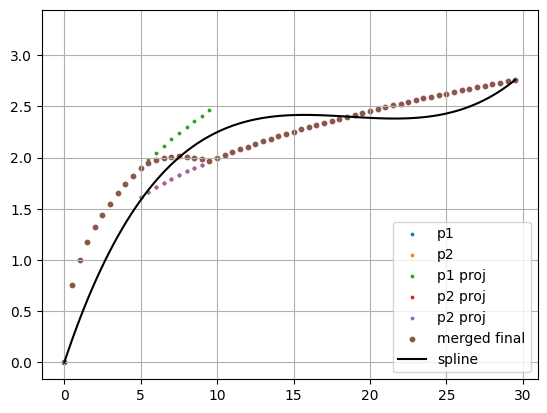

In [292]:
plt.scatter(*p1[:idx1.min()].T, label='p1', s=3)
plt.scatter(*p2.T, label='p2', s=3)
plt.scatter(*proj1.T, label='p1 proj', s=3)
plt.scatter(*proj2.T, label='p2 proj', s=3)
plt.scatter(*proj2.T, label='p2 proj', s=3)
plt.scatter(*merged.T, label='merged final', s=10)
plt.plot(y[0],y[1], label='spline', color='black')
plt.legend()
plt.grid()
plt.xlim(xl)
plt.ylim(yl)
plt.show()

In [429]:
lm = 0.5
k=3
path = merged
cn = len(path)-52
z = getSpeedVector(path)
t = gdk(z,cn-k-1,k)
bs = bspline.Bspline(t, k)
B = np.array([bs._Bspline__basis(zi,k) for zi in z])
B[-1][-1] = 1

P = np.zeros((cn, cn))
P[0][0] = P[-1][-1] = 1
q = np.zeros((cn,2))
q[0] = path[0]
q[-1] = path[-1]

K = constructSecondDerMatrix(z)
Beq = ((1-lm)*(B.T @ B)) + (lm * (B.T @ K @ B))
target = (1-lm)*B.T @ path
LHS = np.concatenate((np.concatenate((Beq, P.T),axis=1), np.concatenate((P, np.zeros((cn,cn))), axis=1)), axis=0)
RHS = np.concatenate((target, q),axis=0)
ctz = np.linalg.lstsq(LHS, RHS, rcond=None)[0]
c = ctz[:cn]

In [431]:
tck = (t/t.max(),c.T,k)
x = np.linspace(0,1,101)
y = interpolate.splev(x,tck)

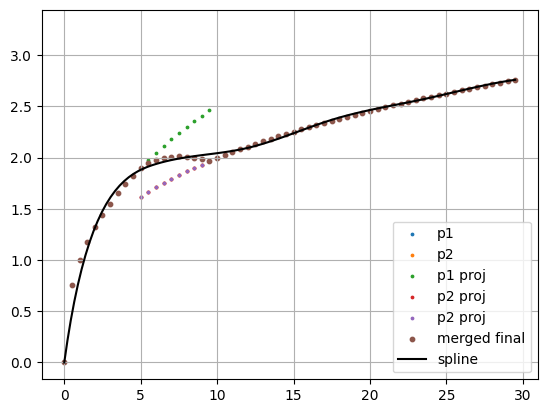

In [433]:
plt.scatter(*p1[:idx1.min()].T, label='p1', s=3)
plt.scatter(*p2.T, label='p2', s=3)
plt.scatter(*proj1.T, label='p1 proj', s=3)
plt.scatter(*proj2.T, label='p2 proj', s=3)
plt.scatter(*proj2.T, label='p2 proj', s=3)
plt.scatter(*merged.T, label='merged final', s=10)
plt.plot(y[0],y[1], label='spline', color='black')
plt.legend()
plt.grid()
plt.xlim(xl)
plt.ylim(yl)
plt.show()